# Prediction methods
## Overview
This notebook explains the deterministic prediction methods used in me stock/crypto analysis tool. We use simple, transparent methods that are easy to understand and validate. We will use a weighted-score-system


### Why This Approach?
-  Transparent and explainable
-  No black-box ML models
-  Easy to adjust and tune
-  Combines multiple signals into one score`


# Retreive data
First, we need some data in order to get a prediction. We use this data to calculate indicators(explanation in indicators_guide), then we'll assign scores. Good indicators get a score of 1, while bad ones get a score of -1. Neutral ones will get a score of 0. Afterwards we use the scores to calculate a trend score by assigning weights, the weights you see are chosen based on my personal opinion.

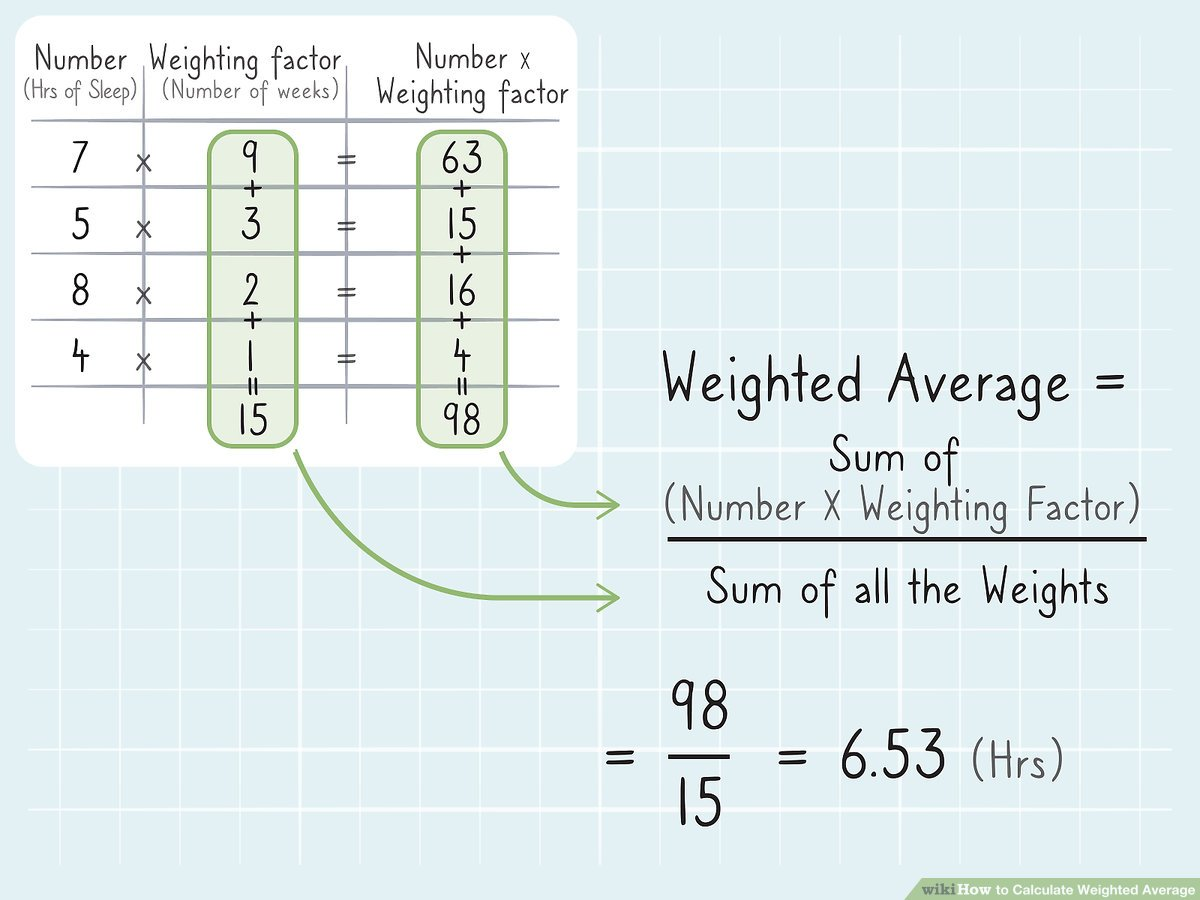 <br>

Here you see a real world example of what a weighted average might look like.

In [ ]:
def retreive_data(data):


    sma_short = sma(data, 30)
    sma_long = sma(data, 100)
    ema_short = ema(data, 12)
    ema_long = ema(data, 26)
    rsi_14 = rsi(data, 14)
    lower_band, upper_band = bollinger_bands(data, 30)
    macd_line, signal_line = macd(data)

    sma_short, sma_long = sma_short.align(sma_long, join='inner')
    sma_diff = (sma_short - sma_long) / sma_long

    ema_short, ema_long = ema_short.align(ema_long, join='inner')
    ema_diff = (ema_short - ema_long) / ema_long

    # if a desired indicator is good, it's score is 1, otherwise -1

    if rsi_14.iloc[-1] > 70:
        rsi_score = 1

    elif rsi_14.iloc[-1] < 30:
        rsi_score = -1

    else:
        rsi_score = 0

    bollinger_percentage = (data['Close'].iloc[-1] - lower_band.iloc[-1]
                            ) / (upper_band.iloc[-1] - lower_band.iloc[-1])

    if bollinger_percentage < 0.2:
        bb_score = -1
    elif bollinger_percentage > 0.5:
        bb_score = 1
    else:
        bb_score = 0

    if macd_line.iloc[-1] > signal_line.iloc[-1]:
        macd_score = 1

    elif macd_line.iloc[-1] < signal_line.iloc[-1]:
        macd_score = -1

    else:
        macd_score = 0

    # weights are chosen of personal opinion, might change later
    trend_score = sma_diff.iloc[-1] * 0.25 + ema_diff.iloc[-1] * \
        0.25 + rsi_score * 0.2 + bb_score * 0.2 + macd_score * 0.2

    return trend_score


# Prediction
We use the trend score in order to add future dates in a set timeframe by a user. In addution to that we use the standard deviation, validation and a smoothing factor of 0.1 to keep the graph in an acceptable range.
Afterwards we concatenate the new row, so we add the new and predicted data to the already existing one.

In [ ]:
def prediction(data, timeframe):
    '''Create a rough estimate of how the future price might develop'''
    # copy data to avoid modifying original dataframe
    data_pred = data.copy()

    std = data_pred['Close'].rolling(window=30).std()
    std_val = min(std.iloc[-1], 10)

    # predict the first 100 days for simplicity and as placeholder

    for i in range(timeframe):

        trend_score = retreive_data(data_pred)

        next_close = data_pred['Close'].iloc[-1] + trend_score * std_val * 0.1

        next_date = pd.bdate_range(start=data_pred.index[-1], periods=2)[1]

        # Create a new row as a DataFrame
        new_row = pd.DataFrame({'Close': [next_close]},  index=[next_date])

        # Concatenate the new row
        # https://pandas.pydata.org/docs/reference/api/pandas.concat.html
        data_pred = pd.concat([data_pred, new_row])

    return data_pred
